# Trabajo Final. Análisis de Datos

## Alumnos:

### Domenje, Carlos R.

### Fux, Santiago.

---

## DATASET: Uso de Taxis Yellow Cab en USA en el año 2020

**Problema.** Responderemos a la siguiente pregunta

1. ¿Existe una manera de caracterizar los lugares más recurrentes para inicio / fin de viaje?


## 1. Obtención de datos

Para importar los datos, buscamos en la página web brindada por la cátedra:

- [Yellow Cab - Dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

**Nota**: El dataset utilizado será el del año 2020, los tres primeros meses (Enero, Febrero, Marzo) y será descargado en una carpeta llamada "data" dentro de la carpeta contenedora del proyecto.

In [62]:
# Path del dataset a utilizar.
DATASET_PATH = r'./data'

In [63]:
# listamos los archivos que se encuentran en el path
!ls {DATASET_PATH}

yellow_tripdata_2020-01.parquet yellow_tripdata_2020-03.parquet
yellow_tripdata_2020-02.parquet


In [64]:
# Importamos las librerias necesarias para interactuar con el dataset.

import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; 
import scipy.stats as stats
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from collections import Counter
# Set decimals format with 3 decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [65]:
# El archivo del dataset tiene como formato .parquet, el cual es un archivo que esta orientado a columnas. 
all_files = glob.glob("./data/*.parquet")

df_list = []

for filename in all_files:
    # Se carga el archivo
    df_all = pd.read_parquet(filename)
    # Tomo el 10% del dataset total   
    df_all = df_all.sample(frac=0.1)
    # Agrego a la lista
    df_list.append(df_all)


df_all = pd.concat(df_list, axis=0, ignore_index=True)


df_all.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1571207.000,1555889.000,1571207.000,1555889.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1555889.000
mean,1.673,1.502,2.904,1.056,164.424,162.270,1.253,12.616,1.106,0.492,2.191,0.333,0.298,18.560,2.296
std,0.470,1.143,45.665,0.704,65.731,69.991,0.486,11.817,1.255,0.073,2.678,1.594,0.035,14.389,0.708
min,1.000,0.000,-30.620,1.000,1.000,1.000,0.000,-1238.000,-4.500,-0.500,-19.170,-21.750,-0.300,-1242.300,-2.500
25%,1.000,1.000,0.970,1.000,125.000,113.000,1.000,6.500,0.000,0.500,0.000,0.000,0.300,11.160,2.500
50%,2.000,1.000,1.600,1.000,162.000,162.000,1.000,9.000,0.500,0.500,1.950,0.000,0.300,14.300,2.500
75%,2.000,2.000,2.930,1.000,234.000,234.000,2.000,14.000,2.500,0.500,2.860,0.000,0.300,19.860,2.500
max,6.000,9.000,57051.090,99.000,265.000,265.000,5.000,750.000,87.560,3.300,445.680,198.000,0.300,840.350,2.750


In [66]:
manhattan_codes = [4,12,13,24,41,42,43,45,48,50,68,74,75,79,87,88,90,100,103,104,105,107,113,114,116,120,125,127,128,137,140,141,142,143,144,148,151,152,153,158,161,162,163,164,166,170,186,194,202,209,211,224,229,230,231,232,233,234,236,237,238,239,243,244,246,249,261,262,263]

In [67]:
df = df_all.query(f'PULocationID in {manhattan_codes} & DOLocationID in {manhattan_codes}')

In [68]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1342566.000,1339662.000,1342566.000,1339662.000,1342566.000,1342566.000,1342566.000,1342566.000,1342566.000,1342566.000,1342566.000,1342566.000,1342566.000,1342566.000,1339662.000
mean,1.669,1.504,1.842,1.012,166.977,165.785,1.250,9.588,1.126,0.496,1.822,0.008,0.298,14.948,2.415
std,0.471,1.147,1.450,0.477,66.078,67.996,0.465,5.828,1.238,0.059,1.667,0.286,0.033,6.877,0.491
min,1.000,0.000,-14.940,1.000,4.000,4.000,0.000,-1238.000,-4.500,-0.500,-19.170,-6.120,-0.300,-1242.300,-2.500
25%,1.000,1.000,0.900,1.000,116.000,114.000,1.000,6.000,0.000,0.500,0.000,0.000,0.300,10.800,2.500
50%,2.000,1.000,1.430,1.000,163.000,163.000,1.000,8.500,0.500,0.500,1.860,0.000,0.300,13.560,2.500
75%,2.000,2.000,2.300,1.000,234.000,234.000,1.000,11.500,2.500,0.500,2.660,0.000,0.300,17.300,2.500
max,2.000,9.000,85.400,99.000,263.000,263.000,4.000,700.000,8.250,2.500,220.000,85.000,0.300,840.350,2.750


In [69]:
## Para obtener una descripción del tipo de datos que contiene cada columna, utilizamos la funcion info()
# Podemos además, obtener una idea general de cuantos datos no nulos contiene.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1342566 entries, 0 to 1571206
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1342566 non-null  int64         
 1   tpep_pickup_datetime   1342566 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1342566 non-null  datetime64[ns]
 3   passenger_count        1339662 non-null  float64       
 4   trip_distance          1342566 non-null  float64       
 5   RatecodeID             1339662 non-null  float64       
 6   store_and_fwd_flag     1339662 non-null  object        
 7   PULocationID           1342566 non-null  int64         
 8   DOLocationID           1342566 non-null  int64         
 9   payment_type           1342566 non-null  int64         
 10  fare_amount            1342566 non-null  float64       
 11  extra                  1342566 non-null  float64       
 12  mta_tax                13425

### Descripción de Columnas del Dataset.


In [70]:
# Listado de tipos de variables presentes en el dataset
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                      object
dtype: object

In [71]:
# funcion para plotear las distribuciones de los atributos
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=10, ylabelsize=10,figsize=(18,18))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout
    plt.show()
    

# funcion para imprimir nulos
def print_null_info(col):
    print(f'Cantidad de nulos: {col.isnull().sum()}/{col.size}')

# funcion para imprimir datos de v. categoricas
def print_categorical(col):
    print(f'Ordinalidad: {col.unique()}')
    print_null_info(col)
    print('Ocurrencias:')
    print(col.value_counts().sort_values())

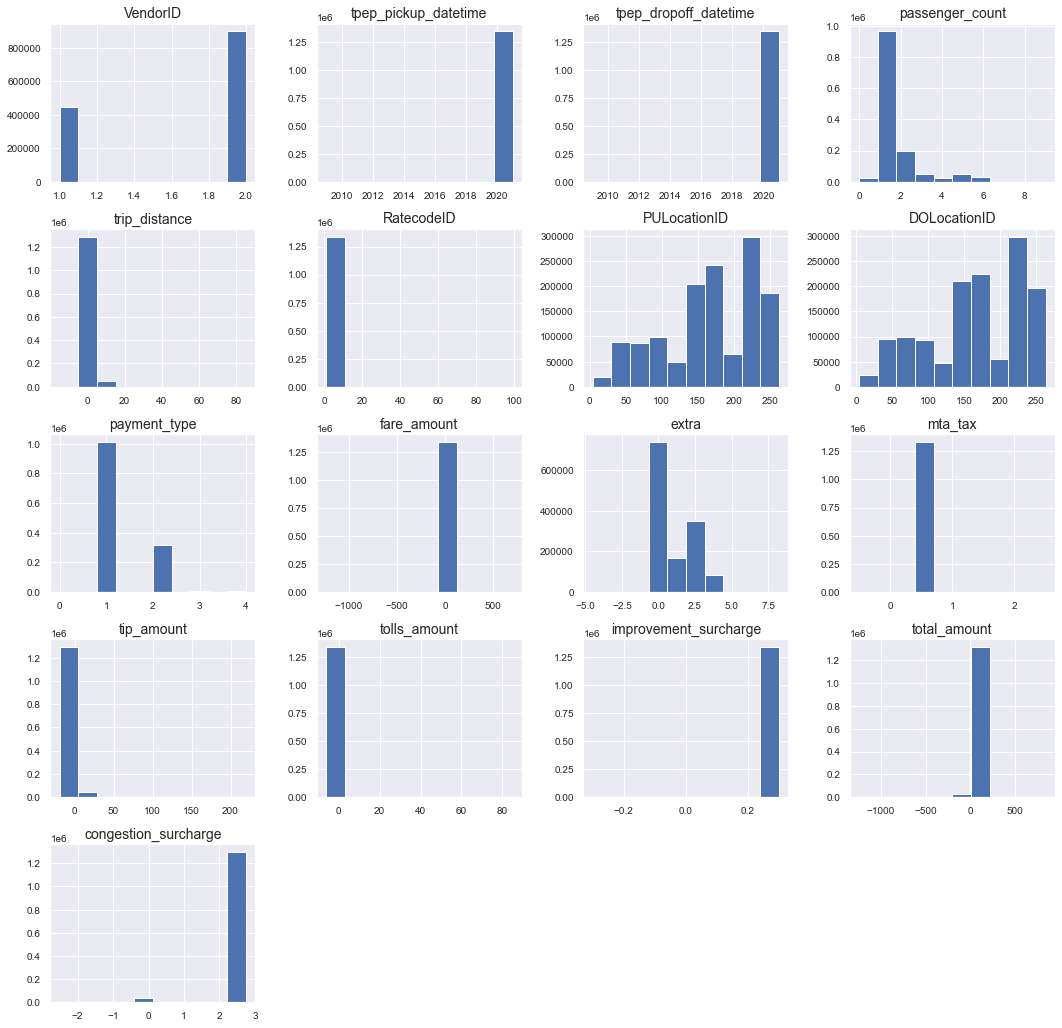

In [72]:
#imprimo distribuciones 
display_dataset_distributions(df)


- **VendorID**: Proveedor de servicios de tecnologias en taxis (T-PEP)
    - Tipo de dato: Categórica ordinal  
    - Tipo de variable: Entrada  


In [73]:
print_categorical(df.VendorID)

Ordinalidad: [2 1]
Cantidad de nulos: 0/1342566
Ocurrencias:
1    444906
2    897660
Name: VendorID, dtype: int64



- **tpep_pickup_datetime**: Fecha y hora en el cual el reloj fue activado al iniciar un viaje.
    - Tipo de dato: Timestamp compuesto  
    - Tipo de variable: Entrada  

    - Ejemplo del dato en el dataset: 2020-07-01 00:25:32


In [74]:
print_null_info(df.tpep_pickup_datetime)

Cantidad de nulos: 0/1342566


- **tpep_dropoff_datetime**: Fecha y hora en el cual el reloj fue desactivador al finalizar un viaje.
    - Tipo de dato: Timestamp compuesto
    - Tipo de variable: Entrada  / Salida

    - Ejemplo del dato en el dataset: 2020-07-01 00:33:39


In [75]:
print_null_info(df.tpep_dropoff_datetime)

Cantidad de nulos: 0/1342566


- **passenger_count**: El número de pasajeros en el vehiculo. (Es un dato que lo ingresa el conductor.)
    - Tipo de dato: Numérico 
    - Tipo de variable: Entrada
    - Ejemplo del dato en el dataset: 1.0

In [76]:
print_null_info(df.passenger_count)

Cantidad de nulos: 2904/1342566



- **trip_distance**: La distancia del viaje transcurrido en millas reportada por el taxímetro. 
    - Tipo de dato: Numérico 
    - Tipo de variable: Entrada  

    - Ejemplo del dato en el dataset: 1.50


In [77]:
print_null_info(df.trip_distance)

Cantidad de nulos: 0/1342566


- **PULocationID**: TLC Zona en la que el taxímetro se activó.
    - Tipo de dato: Categórica ordinal
    - Tipo de variable: Entrada / Salida

    - Ejemplo del dato en el dataset: 238


In [78]:
print_categorical(df.PULocationID)

Ordinalidad: [230  48 164 237 236 229  90 233 137 162 186  24 263  13 141  68 239 163
 170 140 144 234  75 209 142  79 113 238 143 161  43  88  42 125 262 231
 249 246 107 166  50 100   4 232 148 158  87 151 211 114  74 261 224 244
  41 116  12 194  45 152 243 127 202 153 120 128]
Cantidad de nulos: 0/1342566
Ocurrencias:
120        3
128        9
153       11
202       41
194       75
       ...  
186    52187
162    53065
161    62981
236    64516
237    67504
Name: PULocationID, Length: 66, dtype: int64



- **DOLocationID**: TLC Zona en la que el taxímetro se desactivó.
    - Tipo de dato: Categórica ordinal
    - Tipo de variable: Entrada / Salida 

    - Ejemplo del dato en el dataset: 75


In [79]:
print_categorical(df.DOLocationID)

Ordinalidad: [143 137  13 263 100 237  68  41 186 163 161 234 236  90 230  42 164 170
  43 231 209 162  79 141 262 238  75 140 142  87 244 239  45 151 148 114
 233  74 125 229  50 166 113  48 107 261 144 246 152 127 224 116 158 232
  24 249 243   4 211  88  12 194 202 128 120 153]
Cantidad de nulos: 0/1342566
Ocurrencias:
153       60
120       65
128       96
194       98
202      492
       ...  
162    43802
170    46117
161    57431
237    61881
236    68397
Name: DOLocationID, Length: 66, dtype: int64



- **RatecodeID**:  El código de tarifa final vigente al final del viaje.
    - Tipo de dato: Categórica ordinal
    - Tipo de variable: Entrada  

    - 1= Standard rate
    - 2= JFK 
    - 3= Newark
    - 4= Nassau or Westchester
    - 5= Negotiated fare
    - 6= Group ride


In [80]:
print_categorical(df.RatecodeID)

Ordinalidad: [ 1. nan  3.  2.  5. 99.  4.  6.]
Cantidad de nulos: 2904/1342566
Ocurrencias:
6.000           3
99.000         27
4.000          27
3.000         218
2.000        2601
5.000        2627
1.000     1334159
Name: RatecodeID, dtype: int64


- **store_and_fwd_flag**:  Este flag indica si el registro de viaje se llevó a cabo en la memoria del dispositivo del vehiculo antes de enviar al proveedor, también conocido como "almacenar y reenviar", porque el vehiculo no tenia conexion al servidor.
    - Tipo de dato: Categórica  
    - Tipo de variable: Entrada  

    - Y= Almacenar y reenviar informacion.
    - N= No almacenar y enviar informacion.


In [81]:
print_categorical(df.store_and_fwd_flag)

Ordinalidad: ['N' 'Y' None]
Cantidad de nulos: 2904/1342566
Ocurrencias:
Y      13139
N    1326523
Name: store_and_fwd_flag, dtype: int64



- **payment_type**: Un código numérico que significa cómo el pasajero pagó por el viaje.
    - Tipo de dato: Categórica ordinal  
    - Tipo de variable: Entrada  

    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip


In [82]:
print_categorical(df.payment_type)

Ordinalidad: [1 2 0 3 4]
Cantidad de nulos: 0/1342566
Ocurrencias:
0       2904
4       3473
3       5947
2     316641
1    1013601
Name: payment_type, dtype: int64


- **fare_amount**: La tarifa de tiempo y distancia calculada por el taxímetro.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 8.0


In [83]:
print_null_info(df.fare_amount)

Cantidad de nulos: 0/1342566


- **Extra**: Varios extras y recargos. Actualmente, esto solo incluye los cargos de $0.50 y $1 por la hora pico y por la noche.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.5


In [84]:
print_null_info(df.extra)

Cantidad de nulos: 0/1342566



- **mta_tax**: Impuesto MTA de $0.50 que se activa automáticamente según la tasa de uso del medidor.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.5


In [85]:
print_null_info(df.mta_tax)

Cantidad de nulos: 0/1342566


- **improvement_surcharge**: Recargo de mejora de $ 0.30 en viaje en el descenso de bandera. El recargo por mejora comenzó a cobrarse en 2015.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.3


In [86]:
print_null_info(df.improvement_surcharge)

Cantidad de nulos: 0/1342566


- **tip_amount**: Importe de la propina: este campo se completa automáticamente para las propinas de tarjetas de crédito. Las propinas en efectivo no están incluidas.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.00  


In [87]:
print_null_info(df.tip_amount)

Cantidad de nulos: 0/1342566


- **tolls_amount**: Importe total de todos los peajes pagados en el viaje.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  
    - Ejemplo del dato en el dataset: 0.00


In [88]:
print_null_info(df.tolls_amount)

Cantidad de nulos: 0/1342566



- **total_amount**: El monto total cobrado a los pasajeros. No incluye propinas en efectivo.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  
    - Ejemplo del dato en el dataset: 9.30


In [89]:
print_null_info(df.total_amount)

Cantidad de nulos: 0/1342566


- **congestion_surcharge**: Importe total recaudado en el viaje por el recargo por congestión del Estado de Nueva York.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  
    - Ejemplo del dato en el dataset: 0.00


In [90]:
print_null_info(df.congestion_surcharge)

Cantidad de nulos: 2904/1342566


- **airport_fee**: $1.25 para recoger solo en los aeropuertos LaGuardia y John F. Kennedy
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida
    - Ejemplo del dato en el dataset: None

In [91]:
print_null_info(df.airport_fee)

Cantidad de nulos: 1342566/1342566


## 2. Limpieza de los datos


### 2.1 Datos faltantes

In [92]:
# verificamos cantidad de nulos en cada categoría
for i in range(len(df.columns)):
  col_name = df.columns[i]
  col_data = df[col_name]
  print(f'{col_name}: {col_data.isnull().sum()}/{col_data.size}')

VendorID: 0/1342566
tpep_pickup_datetime: 0/1342566
tpep_dropoff_datetime: 0/1342566
passenger_count: 2904/1342566
trip_distance: 0/1342566
RatecodeID: 2904/1342566
store_and_fwd_flag: 2904/1342566
PULocationID: 0/1342566
DOLocationID: 0/1342566
payment_type: 0/1342566
fare_amount: 0/1342566
extra: 0/1342566
mta_tax: 0/1342566
tip_amount: 0/1342566
tolls_amount: 0/1342566
improvement_surcharge: 0/1342566
total_amount: 0/1342566
congestion_surcharge: 2904/1342566
airport_fee: 1342566/1342566


#### 2.1.1 Análisis de faltantes

Las categorías con faltantes son las siguientes:

* passenger_count: 15180/1571072
* RatecodeID: 15180/1571072
* store_and_fwd_flag: 15180/1571072
* congestion_surcharge: 15180/1571072
* airport_fee: 1571072/1571072

Para cada una de estas columnas se decide:
* __passenger_count__ es ingresado a mano por lo que los datos faltantes suponemos que corresponden a fallas en la carga por parte del conductor. Se decide eliminar los faltantes dado que representan el 1%
* __RatecodeID__ no aporta información por lo que se elimina esta feature
* __store_and_fwd_flag__ no aporta información por lo que se elimina esta feature
* __congestion_surcharge__ : los faltantes representan el 1% por lo que se quitan
* __airport_fee__ se quita ya que todos los valores son nulos


In [93]:
# descarto datos nulos de los features con interés (passenger count y congestion_surcharge)
df = df.dropna(subset=['passenger_count', 'congestion_surcharge'])
len(df['passenger_count'])

1339662

#### 2.1.2 Datos no nulos inválidos

En algunos features se detectan valores fuera del rango esperado (tal como valores negativos o fuera del rango de las categorías definidas)

In [94]:
# verificamos cantidad de negativos en las categorías numéricas
cols_to_check = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge']

for i, col in enumerate(cols_to_check):
  col_data = df[col]
  print(f'{col}: {col_data[col_data < 0].count()}/{col_data.size}')
  

trip_distance: 0/1339662
fare_amount: 3918/1339662
extra: 1971/1339662
mta_tax: 3869/1339662
tip_amount: 14/1339662
tolls_amount: 7/1339662
improvement_surcharge: 3917/1339662
total_amount: 3918/1339662
congestion_surcharge: 3706/1339662


In [95]:
# Funcion para realizar subplots de variables

def plotVariables(dataframe, varArray):
    fig = plt.figure(figsize=(30,15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for j,colName in enumerate(varArray):
        plt.subplot(3,3,j+1)
        plt.plot(dataframe[colName])
        plt.title(colName)
        

#### Exploración gráfica de variables con datos negativos

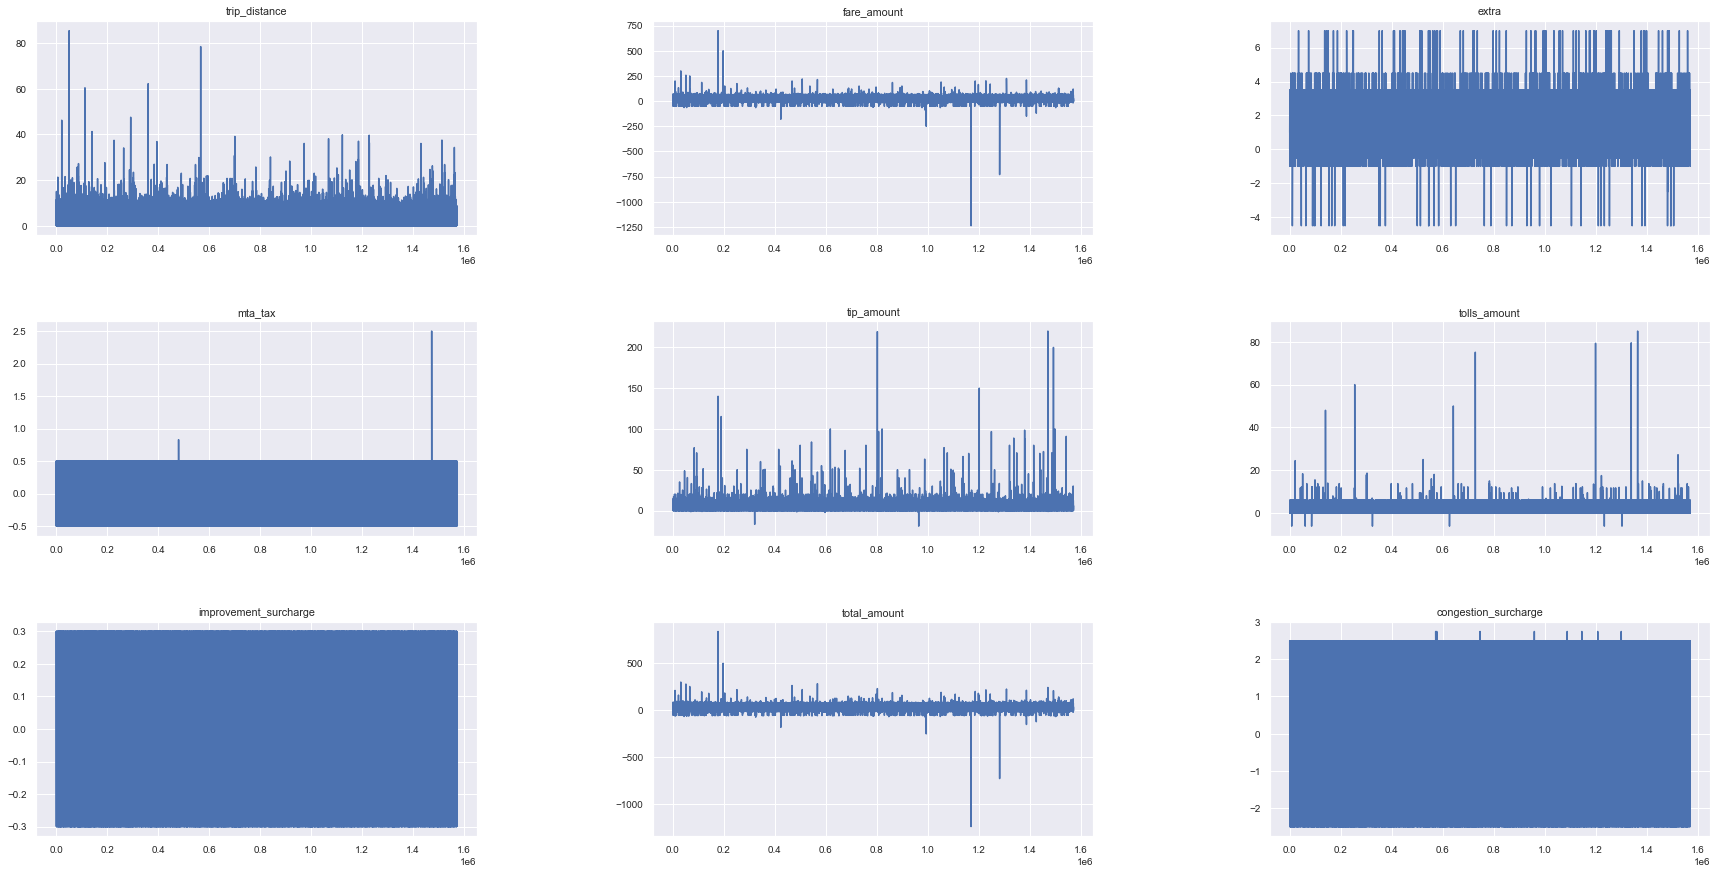

In [96]:
 #TODO: Agrego graficos para mostrar estos datos anomalos.
# Exploración gráfica de variables con datos negativos.

colArrays = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 
            'tip_amount', 'tolls_amount', 'improvement_surcharge', 
            'total_amount', 'congestion_surcharge']

plotVariables(df,colArrays)


In [97]:
# trip distance: borro <= 0
df = df[(df['trip_distance'] > 0)]
# fare_amount: borro < 0
df = df[(df['fare_amount'] >= 0)]
# extra: borro < 0
df = df[(df['extra'] >= 0)]
# mta_tax: borro < 0
df = df[(df['mta_tax'] >= 0)]
# tip_amount: borro < 0
df = df[(df['tip_amount'] >= 0)]
#tolls amount: borro < 0
df = df[(df['tolls_amount'] >= 0)]
#improvement_surcharge: borro < 0
df = df[(df['improvement_surcharge'] >= 0)]
#total_amount: borro < 0
df = df[(df['total_amount'] >= 0)]
#congestion_surcharge: borro < 0
df = df[(df['congestion_surcharge'] >= 0)]

len(df)



1329705

#### Exploración gráfica de datos filtrados


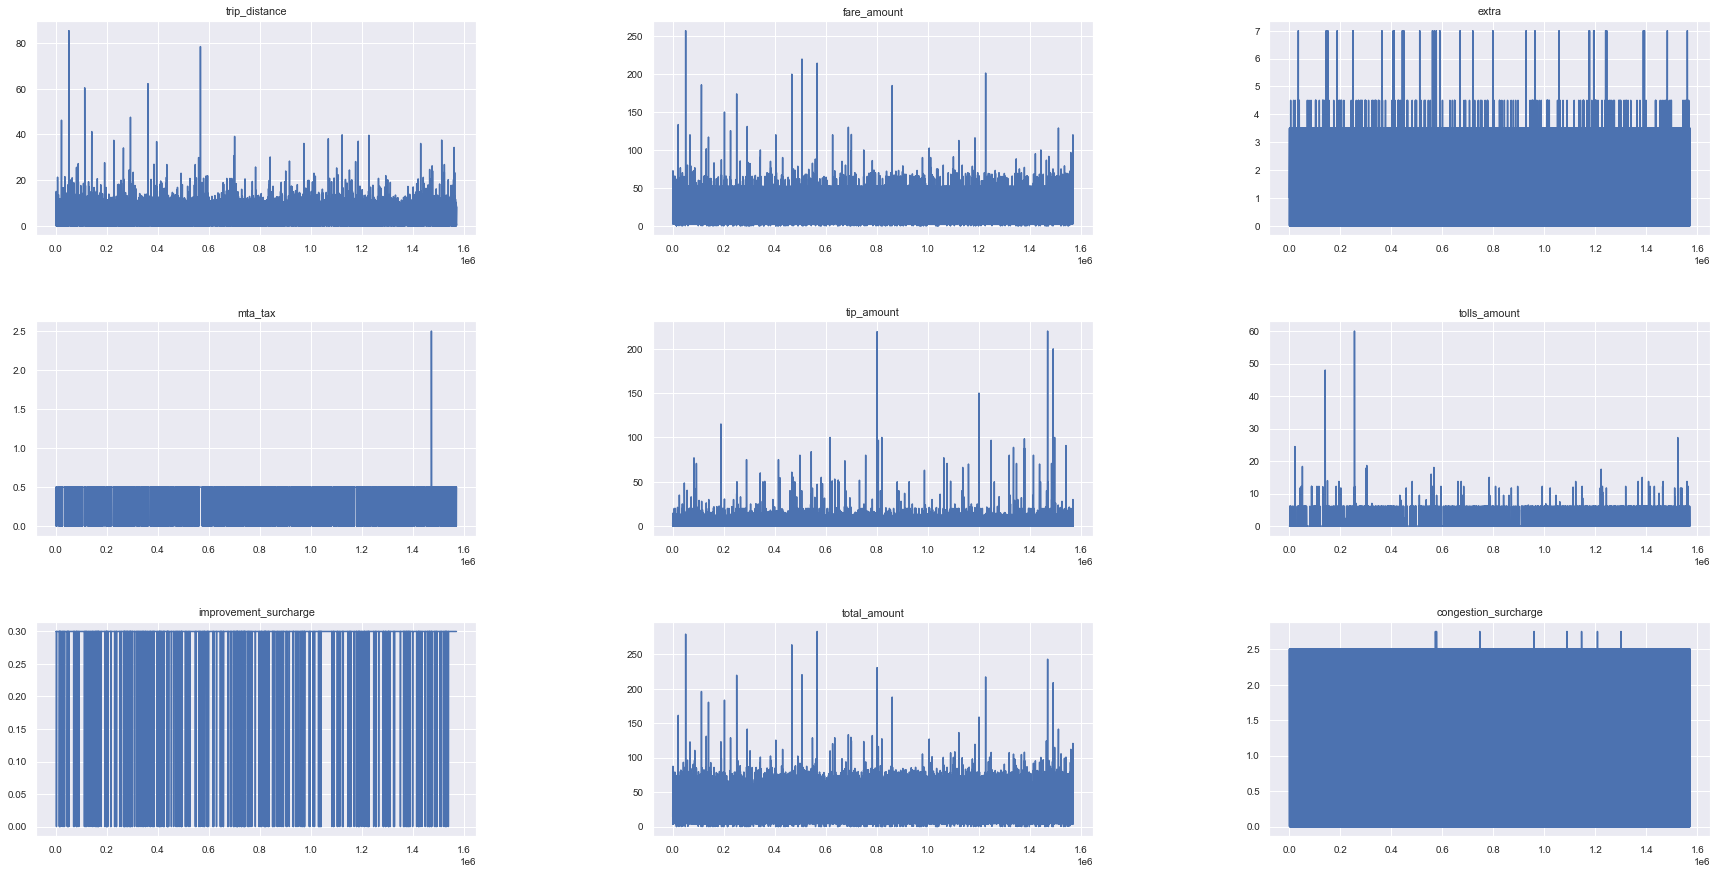

In [98]:
# Datos sin valores negativos
plotVariables(df,colArrays)

#### 2.1.3 Filtro entradas por tipo de pago
Descarto otros pagos diferenes de CREDIT (payment_type = 1)

In [99]:
df = df[df["payment_type"] == 1]
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1009768.000,1009768.000,1009768.000,1009768.000,1009768.000,1009768.000,1009768.000,1009768.000,1009768.000,1009768.000,1009768.000,1009768.000,1009768.000,1009768.000,1009768.000
mean,1.668,1.497,1.891,1.003,168.060,167.048,1.000,9.674,1.143,0.500,2.402,0.006,0.300,15.668,2.453
std,0.471,1.145,1.444,0.098,65.599,67.586,0.000,5.027,1.237,0.012,1.438,0.208,0.002,6.081,0.338
min,1.000,0.000,0.010,1.000,4.000,4.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,0.940,1.000,125.000,114.000,1.000,6.000,0.000,0.500,1.660,0.000,0.300,11.750,2.500
50%,2.000,1.000,1.500,1.000,163.000,163.000,1.000,8.500,0.500,0.500,2.160,0.000,0.300,14.160,2.500
75%,2.000,2.000,2.340,1.000,234.000,234.000,1.000,11.500,2.500,0.500,2.960,0.000,0.300,18.300,2.500
max,2.000,9.000,85.400,5.000,263.000,263.000,1.000,257.500,7.000,2.500,220.000,60.000,0.300,283.020,2.750


### 2.2 Ingeniería de datos

#### 2.2.1 Features de tiempo y hora del día

In [100]:
# generamos una nueva columna "duration" con el tiempo de viaje
ts_init = pd.to_datetime(df['tpep_pickup_datetime']).values.astype(np.int64) / 1000000000
ts_end = pd.to_datetime(df['tpep_dropoff_datetime']).values.astype(np.int64) / 1000000000
duration = ts_end - ts_init
df['duration'] = duration

# ademas creamos 3 categorías para el horario en que se inició el viaje: diurno, vespertino y nocturno
MORNING_START = 6
MORNING_END = 13
AFTERNOON_START = 14
AFTERNOON_END = 20
EVENING_START = 21
EVENING_END = 5 

day_interval = df['tpep_pickup_datetime'].dt.hour
df['morning'] = pd.cut(day_interval, bins=[-float('Inf'), MORNING_START - 1, MORNING_END, float('Inf')], labels=[0, 1, 0], ordered=False)
df['afternoon'] = pd.cut(day_interval, bins=[-float('Inf'), AFTERNOON_START - 1, AFTERNOON_END, float('Inf')], labels=[0, 1, 0], ordered=False)
df['evening'] = pd.cut(day_interval, bins=[-float('Inf'), 0, EVENING_END, EVENING_START, 23, float('Inf')], labels=[0, 1, 0, 1, 0], ordered=False)

# reviso que sean validas 
df['morning'].values.isnull().sum(), df['afternoon'].values.isnull().sum(), df['evening'].values.isnull().sum()

(0, 0, 0)

In [101]:
# termino de borrar todos los negativos
df['morning'].values.isnull().sum(), df['afternoon'].values.isnull().sum(), df['evening'].values.isnull().sum()

# verifico si tengo entradas con duration < 0
duration_invalid = df[df['duration'] < 0]['duration'].count()
print(f'Duraciones inválidas: {duration_invalid}')

Duraciones inválidas: 0


In [102]:
# Se eliminan las duraciones invalidas
df = df[(df['duration'] > 0)]

#### 2.2.2 Codificación del origen

En __PULocationID__ vamos a analizar qué cantidad de locations representan el 90% de los datos y cuántas categorías necesito para poder agrupar en una categoría "Otros" a un grupo ecualizado

In [103]:
puids = df['PULocationID'].value_counts(sort=True, ascending=False)
sum = 0
total_cats = 0
total_items = len(df)
tot_cats_eq = 0
for i, x in enumerate(puids):
  if sum < (0.9*total_items):
    sum += x
    total_cats += 1
  
  total_others = np.sum(puids[(i + 1):]) if i < (len(puids) - 1) else 0
  if x < total_others:
    tot_cats_eq += 1 
print(f'PULocationIDs que representan el 90% = {total_cats} con {sum} items de un total de {total_items}')
print(f'Total de categorías que necesito para que Others esté ecualizado = {tot_cats_eq}')


PULocationIDs que representan el 90% = 36 con 918421 items de un total de 1009751
Total de categorías que necesito para que Others esté ecualizado = 60


__Conclusión:__ Vemos que necesitamos 36 categorías para representar el 90% de las categorías de PULocationID y que precisamos 59 categorías para tener una categoría Others ecualizada

En las columnas PULocationID tenemos una alta ordinalidad. Por esto vamos a hacer un __frequency encoding__ en PULOcationID (variable de entrada) donde:
* __PULocationIDFreq90percent__: Columna con freq encoding con los locations que representan el 90%
* __PULocationIDFreqEq__: Columna con freq encoding con los locations que integran la columna Others de forma ecualizada
* __PULocationIDFreqTop10__: Columna con freq encoding con las 10 primeras locations


In [104]:
# convertimos PULocationID usando frequency encoding
pulocation_id_freq_map = df['PULocationID'].value_counts(normalize=True, sort=True).to_dict()

df['PULocationIDFreq'] = df['PULocationID'].apply(lambda x: pulocation_id_freq_map[x])

#codifico en frecuencia para el 90%
df['PULocationIDFreq90percent'] = df['PULocationID'].apply(lambda x: pulocation_id_freq_map[x] if x in list(pulocation_id_freq_map)[:36] else 0).round(4)

#codifico en frecuencia para las categorias ecualizadas 
df['PULocationIDFreqEq'] = df['PULocationID'].apply(lambda x: pulocation_id_freq_map[x] if x in list(pulocation_id_freq_map)[:59] else 0).round(4)

#codifico en frecuencia para las 10 más importantes
df['PULocationIDFreqTop10'] = df['PULocationID'].apply(lambda x: pulocation_id_freq_map[x] if x in list(pulocation_id_freq_map)[:10] else 0).round(4)

df['PULocationIDFreq90percent'].unique().size, df['PULocationIDFreqEq'].unique().size, df['PULocationIDFreqTop10'].unique().size


(36, 55, 11)

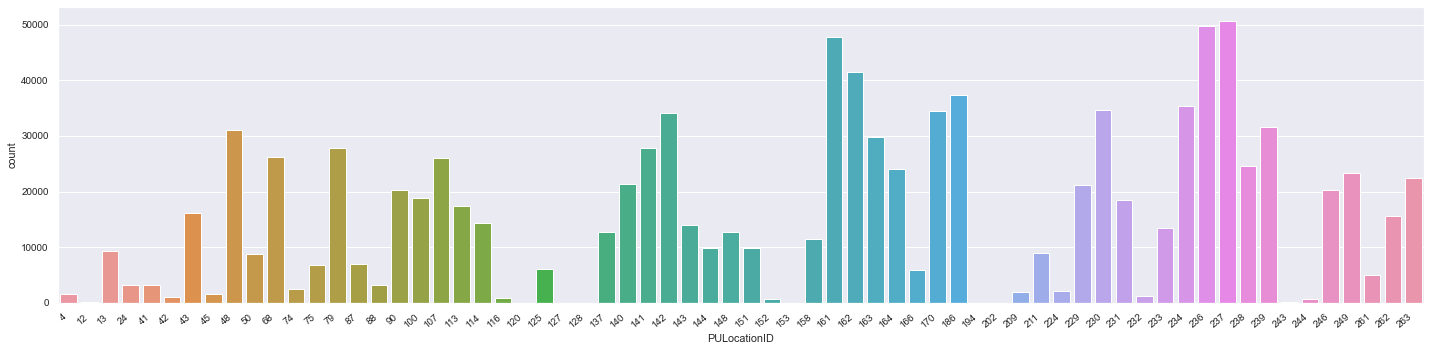

In [105]:
# Grafico de PULocationID
plt.figure(figsize=(20,5))
ax = sns.countplot(data=df, x='PULocationID')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

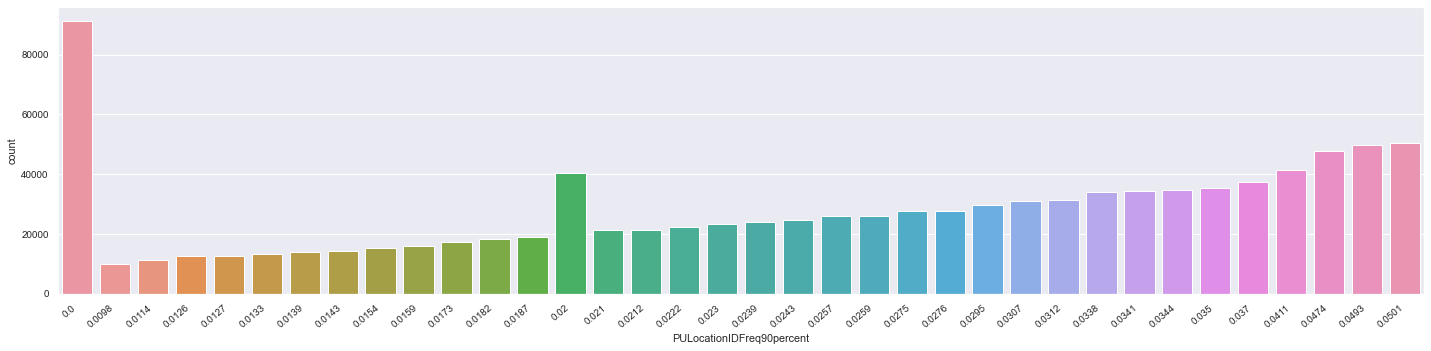

In [106]:
# Grafico de PULocationID Frecuencia del 90%
plt.figure(figsize=(20,5))
ax = sns.countplot(data=df, x='PULocationIDFreq90percent')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

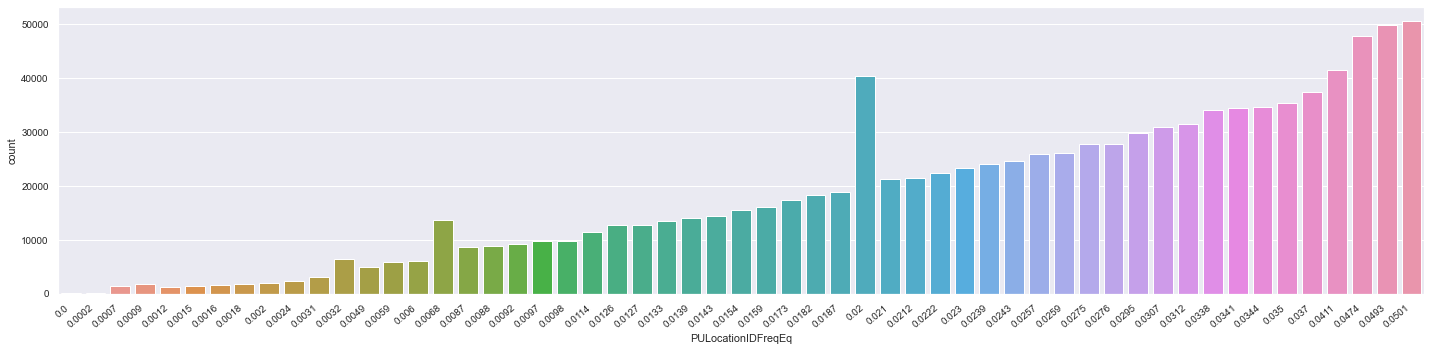

In [107]:
# Grafico de PULocationID frecuencia equalizada
plt.figure(figsize=(20,5))
ax = sns.countplot(data=df, x='PULocationIDFreqEq')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

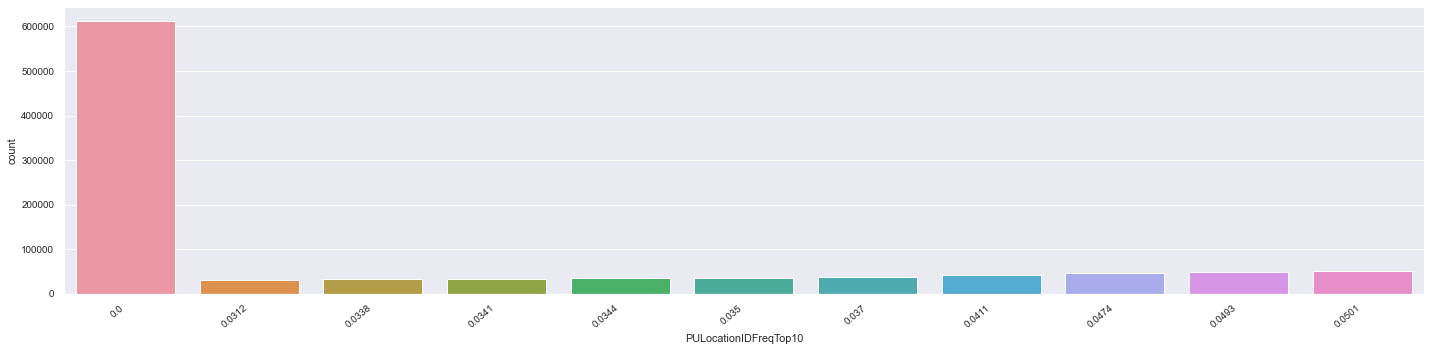

In [108]:
# Grafico de PULocationID frecuencia Top 10
plt.figure(figsize=(20,5))
ax = sns.countplot(data=df, x='PULocationIDFreqTop10')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

#### 2.2.3 Balance de la variable de salida

En __DOLocationID__ vamos a analizar qué cantidad de locations representan el 90% de los datos y cuántas categorías necesito para poder agrupar en una categoría "Otros" a un grupo ecualizado

In [109]:
doids = df['DOLocationID'].value_counts(sort=True, ascending=False)
sum = 0
total_cats = 0
total_items = len(df)
tot_cats_eq = 0
for i, x in enumerate(doids):
  if sum < (0.9*total_items):
    sum += x
    total_cats += 1

  total_others = np.sum(doids[(i + 1):]) if i < (len(doids) - 1) else 0
  if x < total_others:
    tot_cats_eq += 1 

print(f'DOLocationIDs que representan el 90% = {total_cats} con {sum} items de un total de {total_items}')
print(f'Total de categorías que necesito para que Others esté ecualizado = {tot_cats_eq}')

DOLocationIDs que representan el 90% = 39 con 909725 items de un total de 1009751
Total de categorías que necesito para que Others esté ecualizado = 62


__Conclusión:__ Vemos que necesitamos 39 categorías para representar el 90% de las categorías de DOLocationID y que precisamos 63 categorías para tener una categoría Others ecualizada

En las columnas DOLocationID tenemos una alta ordinalidad. Por esto vamos a hacer una selección en DOLocationID (variable de salida) donde:
* __DOLocationID90percent__: Columna con freq encoding con los locations que representan el 90%
* __DOLocationIDEq__: Columna con los locations que integran la columna Others de forma ecualizada
* __DOLocationIDTop10__: Columna con las 10 primeras locations


In [110]:
#verifico el rango de los ids
df['DOLocationID'].min(), df['DOLocationID'].max()


(4, 263)

In [111]:
# generamos alternativas
dolocation_id_freq_map = df['DOLocationID'].value_counts(normalize=False, sort=True).to_dict()

df['DOLocationID90percent'] = df['DOLocationID'].apply(lambda x: x if x in list(dolocation_id_freq_map)[:39] else 0)
df['DOLocationIDEq'] = df['DOLocationID'].apply(lambda x: x if x in list(dolocation_id_freq_map)[:64] else 0)
df['DOLocationIDTop10'] = df['DOLocationID'].apply(lambda x: x if x in list(dolocation_id_freq_map)[:10] else 0)

df['DOLocationID90percent'].unique().size, df['DOLocationIDEq'].unique().size, df['DOLocationIDTop10'].unique().size


(40, 65, 11)

In [112]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,...,total_amount,congestion_surcharge,duration,PULocationIDFreq,PULocationIDFreq90percent,PULocationIDFreqEq,PULocationIDFreqTop10,DOLocationID90percent,DOLocationIDEq,DOLocationIDTop10
count,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000,...,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000,1009751.000
mean,1.668,1.497,1.891,1.003,168.060,167.048,1.000,9.674,1.143,0.500,...,15.668,2.453,810.007,0.028,0.027,0.028,0.016,153.709,167.042,71.384
std,0.471,1.145,1.444,0.098,65.599,67.586,0.000,5.027,1.237,0.012,...,6.081,0.338,3374.092,0.013,0.014,0.013,0.020,80.495,67.595,97.999
min,1.000,0.000,0.010,1.000,4.000,4.000,1.000,0.000,0.000,0.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,0.940,1.000,125.000,114.000,1.000,6.000,0.000,0.500,...,11.750,2.500,376.000,0.019,0.019,0.019,0.000,100.000,114.000,0.000
50%,2.000,1.000,1.500,1.000,163.000,163.000,1.000,8.500,0.500,0.500,...,14.160,2.500,589.000,0.028,0.028,0.028,0.000,161.000,163.000,0.000
75%,2.000,2.000,2.340,1.000,234.000,234.000,1.000,11.500,2.500,0.500,...,18.300,2.500,885.000,0.035,0.035,0.035,0.035,234.000,234.000,162.000
max,2.000,9.000,85.400,5.000,263.000,263.000,1.000,257.500,7.000,2.500,...,283.020,2.750,116777.000,0.050,0.050,0.050,0.050,263.000,263.000,239.000


<AxesSubplot:xlabel='duration', ylabel='trip_distance'>

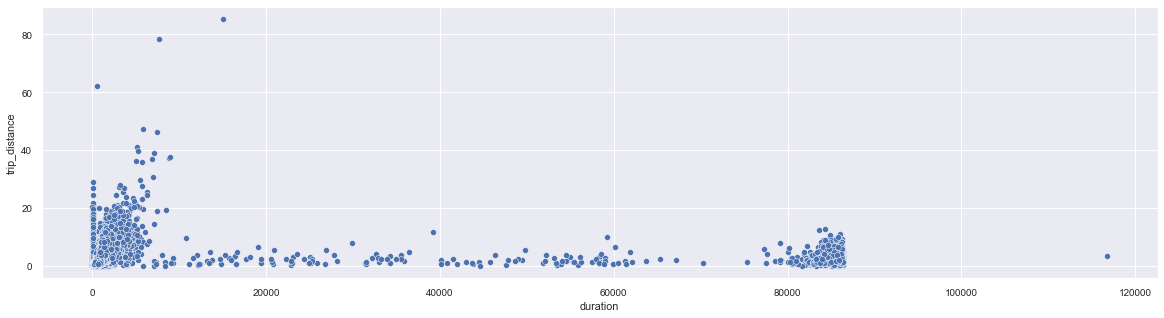

In [113]:
# Grafico de duracion de viaje vs distancia recorrida.
plt.figure(figsize=(20,5))
sns.scatterplot(x='duration', y='trip_distance', data=df)

<AxesSubplot:xlabel='trip_distance', ylabel='total_amount'>

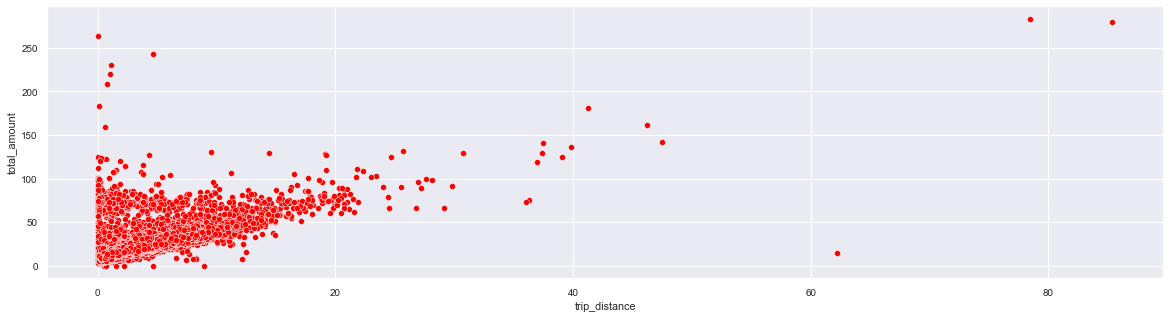

In [114]:
# Grafico de duracion de viaje vs total cobrado.
plt.figure(figsize=(20,5))
sns.scatterplot(x='trip_distance', y='total_amount', data=df, color='red')

<AxesSubplot:xlabel='trip_distance', ylabel='tip_amount'>

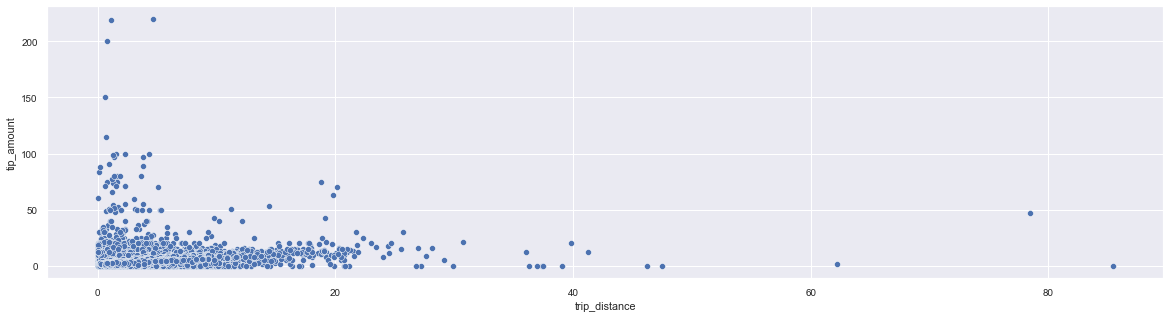

In [115]:
# Grafico de duracion de viaje vs propinas.
plt.figure(figsize=(20,5))
sns.scatterplot(x='trip_distance', y='tip_amount', data=df)

<AxesSubplot:xlabel='tip_amount', ylabel='total_amount'>

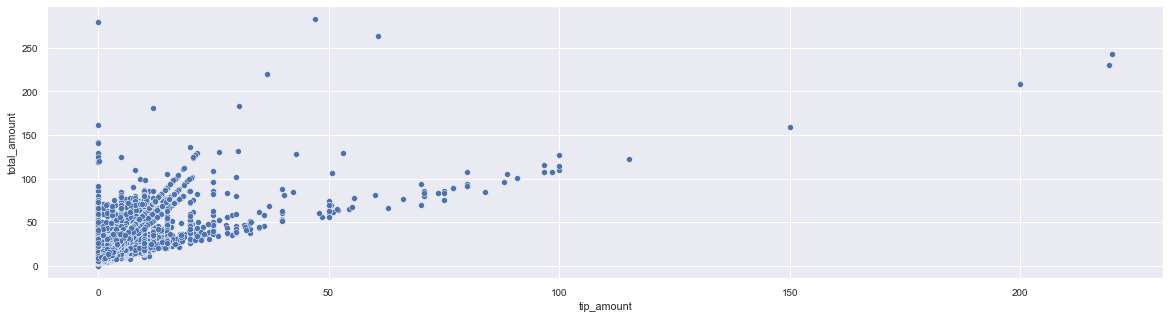

In [116]:
# Grafico de propinas vs total_cobrado.
plt.figure(figsize=(20,5))
sns.scatterplot(x='tip_amount', y='total_amount', data=df)

<AxesSubplot:xlabel='total_amount', ylabel='Count'>

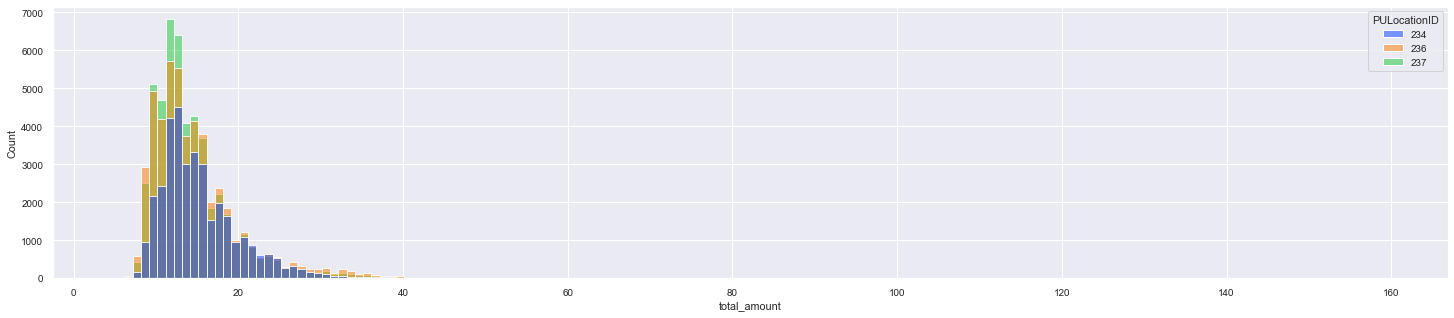

In [117]:
df_aux = df.loc[(df['PULocationID'] == 237) | (df['PULocationID'] == 236) | (df['PULocationID'] == 234)]

plt.figure(figsize=(25,5))
sns.histplot(data=df_aux, x='total_amount',hue='PULocationID', binwidth=1, palette='bright')


<AxesSubplot:xlabel='tip_amount', ylabel='Count'>

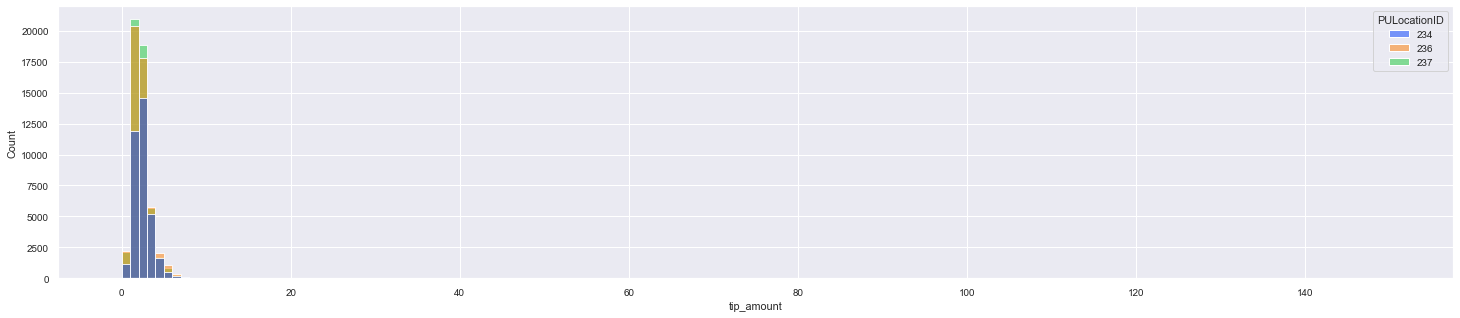

In [118]:
plt.figure(figsize=(25,5))
sns.histplot(data=df_aux, x='tip_amount',hue='PULocationID', binwidth=1, palette='bright')

<AxesSubplot:xlabel='total_amount', ylabel='Count'>

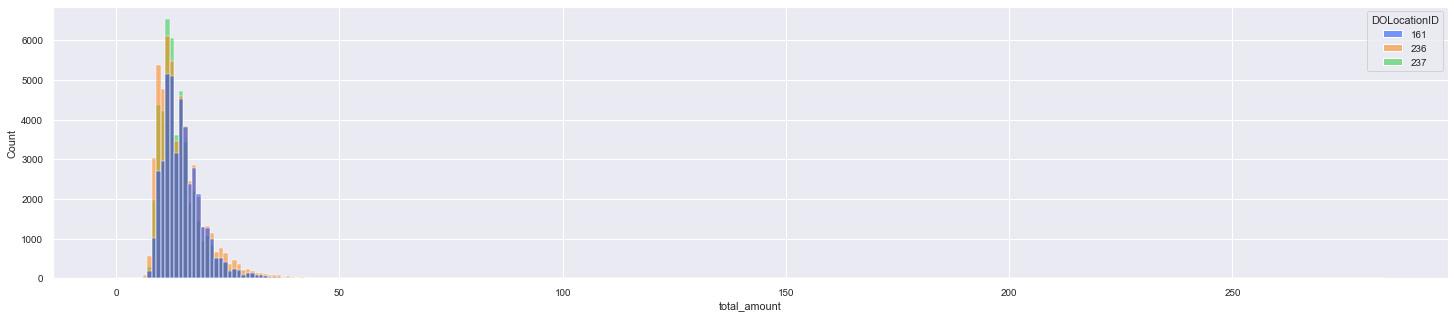

In [119]:
# Grafico de lugares donde se finalizo el viaje con mayor valor cobrado.
df_aux_do = df.loc[(df['DOLocationID'] == 237) | (df['DOLocationID'] == 236) | (df['DOLocationID'] == 161)]
plt.figure(figsize=(25,5))
sns.histplot(data=df_aux_do, x='total_amount',hue='DOLocationID', binwidth=1, palette='bright')

<AxesSubplot:xlabel='tip_amount', ylabel='Count'>

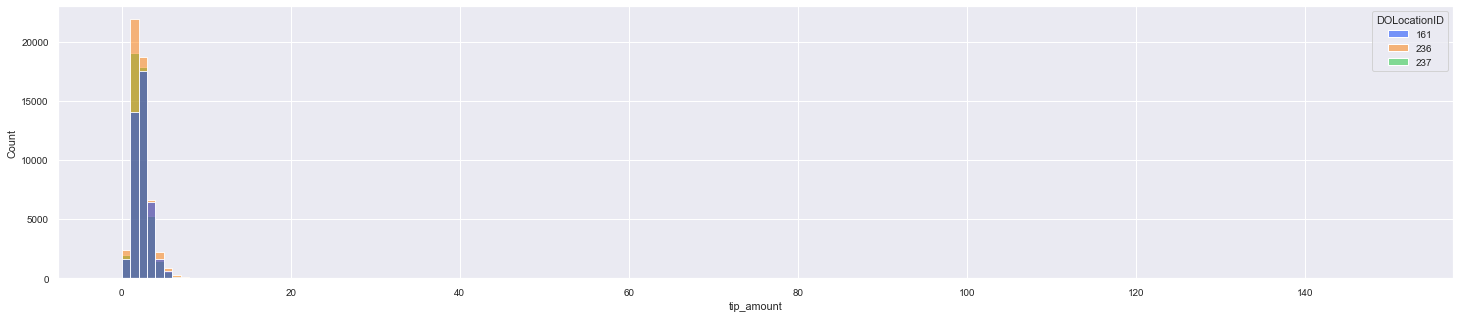

In [120]:
# Grafico de lugares donde se finalizo el viaje con mayor valor de propina.
df_aux_do = df.loc[(df['DOLocationID'] == 237) | (df['DOLocationID'] == 236) | (df['DOLocationID'] == 161)]
plt.figure(figsize=(25,5))
sns.histplot(data=df_aux_do, x='tip_amount',hue='DOLocationID', binwidth=1, palette='bright')

### 2.3 Selección final de las features

#### Eliminacion de datos con baja varianza

In [121]:
from statistics import variance
from sklearn.feature_selection import VarianceThreshold

feature_cols = [
  'passenger_count', 'trip_distance', 'fare_amount', 'extra', 
  'mta_tax', 'tip_amount', 'tolls_amount', 
  'improvement_surcharge', 'total_amount', 
  'congestion_surcharge', 'duration', 'PULocationIDFreq', 'PULocationIDFreqEq', 'PULocationIDFreqTop10', 'PULocationIDFreq90percent', 
  'morning', 'afternoon', 'evening']

X = df[feature_cols]

constant_filter = VarianceThreshold(threshold=0.01)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(X)
print(X.shape)
print(data_constant.shape)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in X.columns
                    if column not in X.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))
#Constant columns names:
for column in constant_columns:
    print(column)
    

(1009751, 18)
(1009751, 12)
6
mta_tax
improvement_surcharge
PULocationIDFreq
PULocationIDFreqEq
PULocationIDFreqTop10
PULocationIDFreq90percent


__Conclusión__: se decide eliminar las columnas __mta_tax__ e __improvement_surcharge__ de los datasets a procesar dada su baja varianza.  
En los features asociados a PULocationIDFreq no los descartamos dado que fueron generados por nosotros anteriormente.

#### Selección de features con el coeficiente de Kendall

El coeficiente de Kendall permite analizar la correlación entre variables numéricas de entrada y una variable de salida categórica (DOLocationID). 
- Test de correlación de Kendall: 
    - Test no paramétrico, i.e. no asume ninguna distribución de los datos
    - $H_0$: Las variables son independientes, $H_1$: Las variables no son independientes.
    - Se basa en el estadístico $\tau = {\frac {2}{n(n-1)}}\sum _{i<j}{sgn}(x_{i}-x_{j}){sgn}(y_{i}-y_{j})$ 
    - Orden $n^2$, si hay muchos datos puede ser muy costoso.

/opt/miniconda3/envs/pycartetEnv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4868: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


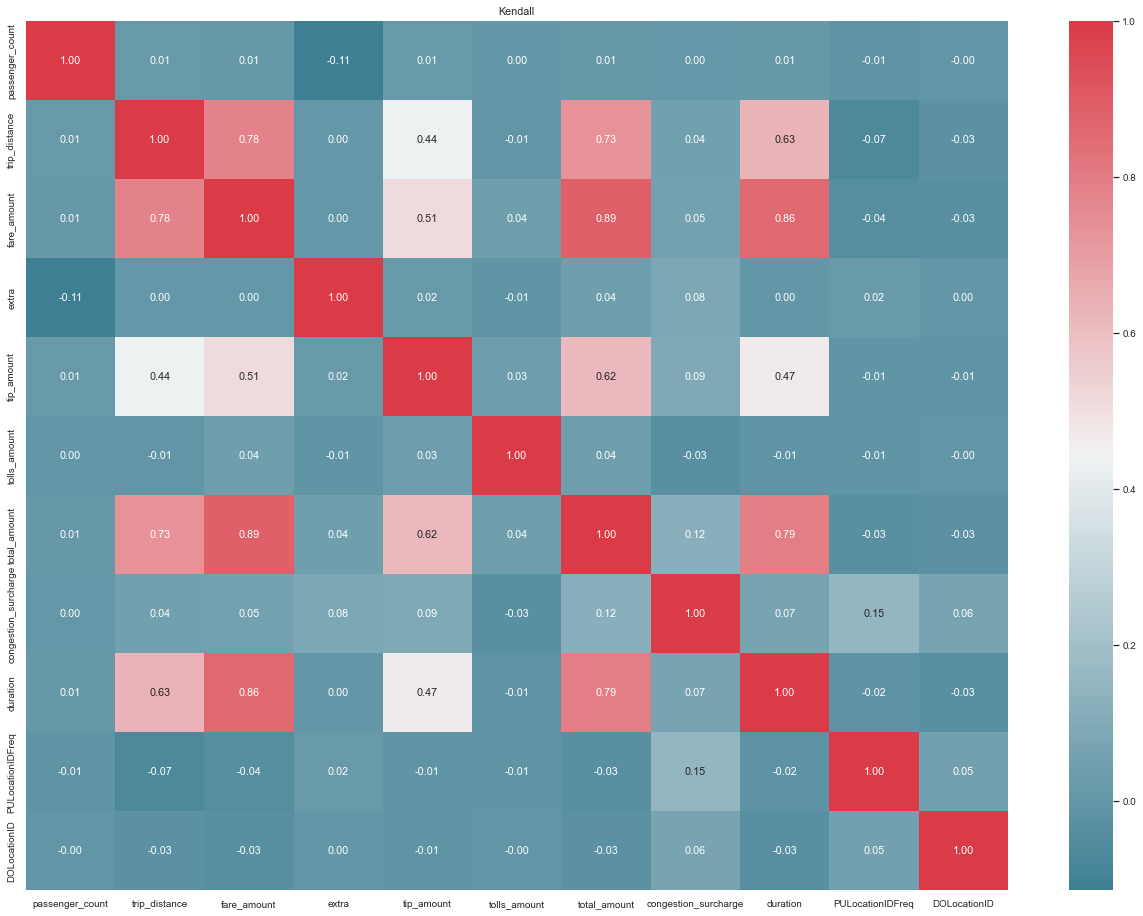

In [122]:
fig, axes = plt.subplots(1,1,figsize=(22,16))

#armo listado de variables de entrada y salida a analizar
kendall_cols = [
  'passenger_count', 'trip_distance', 'fare_amount', 'extra', 
  'tip_amount', 'tolls_amount', 
  'total_amount', 
  'congestion_surcharge', 'duration', 'PULocationIDFreq',
  'morning', 'afternoon', 'evening', 'DOLocationID']

kendall_df = df[kendall_cols]
tau = kendall_df.corr(method='kendall')
axes.set_title("Kendall")
sns.heatmap(tau, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

__Conclusión__:  
Se detectan correlaciones fuertes (superior al 75%) entre los siguientes features:  
* fare_amount - trip_distance (0.78)
* total_amount - fare_amount (0.89)
* duration - fare_amount (0.86)
* duration - total_amount (0.79)

Se concluye que podría llegar a seleccionarse entre total_amount y fare_amount en lugar de avanzar con ambas dada su alto grado de correlación

## 3.Entrenamiento de modelos 
### 3.1 Separación de datos


In [123]:
# Particionamos en train y test
train_ratio = 0.7
test_ratio = 0.3

#genero los datasets

X_eq = df[[
  'passenger_count', 'trip_distance', 'fare_amount', 'extra', 
  'tip_amount', 'tolls_amount', 
  'total_amount', 
  'congestion_surcharge', 'duration', 'PULocationIDFreqEq',
  'morning', 'afternoon', 'evening']]
y_eq = df['DOLocationIDEq']

X_top10 = df[df['DOLocationIDTop10'] > 0][[
  'passenger_count', 'trip_distance', 'fare_amount', 'extra', 
  'tip_amount', 'tolls_amount', 
  'total_amount', 
  'congestion_surcharge', 'duration', 'PULocationIDFreqTop10',
  'morning', 'afternoon', 'evening']]
y_top10 = df[df['DOLocationIDTop10'] > 0]['DOLocationIDTop10']

X_90percent = df[df['DOLocationID90percent'] > 0][[
  'passenger_count', 'trip_distance', 'fare_amount', 'extra', 
  'tip_amount',
  'total_amount', 
  'congestion_surcharge', 'duration', 'PULocationIDFreq90percent',
  'morning', 'afternoon', 'evening']]
y_90percent = df[df['DOLocationID90percent'] > 0]['DOLocationID90percent']

X_train_eq, X_test_eq, y_train_eq, y_test_eq = train_test_split(X_eq, y_eq, stratify=y_eq, random_state=1)
X_train_top10, X_test_top10, y_train_top10, y_test_top10 = train_test_split(X_top10, y_top10, stratify=y_top10, random_state=1)
X_train_90percent, X_test_90percent, y_train_90percent, y_test_90percent = train_test_split(X_90percent, y_90percent, stratify=y_90percent, random_state=1)


In [124]:
#imprimo tamaños de los dataset de train y test
print(f'Eq: train/test len={len(X_train_eq)}/{len(X_test_eq)}')
print(f'Top10: train/test len={len(X_train_top10)}/{len(X_test_top10)}')
print(f'90%: train/test len={len(X_train_90percent)}/{len(X_test_90percent)}')

Eq: train/test len=757313/252438
Top10: train/test len=273580/91194
90%: train/test len=682293/227432


### 3.2 Random Forest

Dataset EQ:


/opt/miniconda3/envs/pycartetEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           4       0.00      0.00      0.00      1103
          12       0.00      0.00      0.00       108
          13       0.11      0.22      0.15      2447
          24       0.00      0.00      0.00       900
          41       0.17      0.01      0.02      1561
          42       0.00      0.00      0.00       870
          43       0.00      0.00      0.00      3274
          45       0.00      0.00      0.00       570
          48       0.08      0.02      0.03      6839
          50       0.00      0.00      0.00      3234
          68       0.00      0.00      0.00      6408
          74       0.20      0.11      0.15      1781
          75       0.15      0.00      0.00      3216
          79       0.08      0.22      0.11      6513
          87       0.10      0.13      0.11      2255
          88       0.00      0.00      0.00       967
          90       0.00    

/opt/miniconda3/envs/pycartetEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         141       0.00      0.00      0.00      7716
         142       0.30      0.02      0.04      8022
         161       0.19      0.54      0.29     10569
         162       0.00      0.00      0.00      8246
         170       0.22      0.31      0.26      8931
         230       0.32      0.00      0.00      6940
         234       0.36      0.01      0.02      7968
         236       0.23      0.68      0.35     13304
         237       0.23      0.14      0.17     11606
         239       0.40      0.12      0.19      7892

    accuracy                           0.22     91194
   macro avg       0.23      0.18      0.13     91194
weighted avg       0.23      0.22      0.15     91194

Dataset 90Percent:


/opt/miniconda3/envs/pycartetEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          13       0.20      0.24      0.22      2447
          43       0.00      0.00      0.00      3274
          48       0.15      0.03      0.05      6839
          50       0.00      0.00      0.00      3234
          68       0.00      0.00      0.00      6408
          75       0.34      0.12      0.18      3216
          79       0.09      0.25      0.13      6512
          90       0.00      0.00      0.00      4445
         100       0.00      0.00      0.00      3832
         107       0.00      0.00      0.00      6268
         113       0.00      0.00      0.00      4015
         114       0.00      0.00      0.00      2906
         137       0.00      0.00      0.00      3943
         140       0.00      0.00      0.00      5676
         141       0.00      0.00      0.00      7716
         142       0.22      0.02      0.04      8023
         143       0.00      0.00      0.00      4307
         148       0.00    

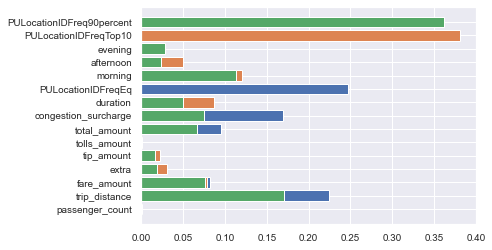

In [125]:
#santiago multi modelos en random forest
from sklearn.ensemble import RandomForestClassifier
total_trees = 100 # number of trees
max_depth = 5

def run_random_forest(x_tr, x_te, y_tr, y_te):

  rf_aux = RandomForestClassifier(n_estimators = total_trees, criterion = 'entropy', max_depth = max_depth, random_state=0)
  rf_aux.fit(x_tr, y_tr.values.reshape(-1))
  # Utilizamos el método de predicción en los datos de prueba
  y_rf_pred_aux = rf_aux.predict(x_te)
  print(classification_report(y_te,y_rf_pred_aux))
  #grafico los features segun su importancia
  plt.barh(x_tr.columns, rf_aux.feature_importances_)

print(f'Dataset EQ:')
run_random_forest(X_train_eq, X_test_eq, y_train_eq, y_test_eq)
print(f'Dataset Top10:')
run_random_forest(X_train_top10, X_test_top10, y_train_top10, y_test_top10)
print(f'Dataset 90Percent:')
run_random_forest(X_train_90percent, X_test_90percent, y_train_90percent, y_test_90percent)

### 3.3 Regresión logística

In [127]:
def run_lr(x_tr, x_te, y_tr, y_te):
  scaler = StandardScaler()  
  X_train_sc = scaler.fit_transform(x_tr) # Estandarizamos los datos     
  X_test_sc = scaler.transform(x_te)

  lr = LogisticRegression(random_state = 1, max_iter=1000, n_jobs=-1)
  lr.fit(X_train_sc,y_tr)
  y_lr_pred = lr.predict(X_test_sc)
  print(classification_report(y_te,y_lr_pred))

print(f'Dataset EQ:')
run_lr(X_train_eq, X_test_eq, y_train_eq, y_test_eq)
print(f'Dataset Top10:')
run_lr(X_train_top10, X_test_top10, y_train_top10, y_test_top10)
print(f'Dataset 90Percent:')
run_lr(X_train_90percent, X_test_90percent, y_train_90percent, y_test_90percent)


Dataset Top10:
              precision    recall  f1-score   support

         141       0.18      0.02      0.03      7716
         142       0.20      0.00      0.00      8022
         161       0.18      0.42      0.25     10569
         162       0.21      0.00      0.00      8246
         170       0.17      0.25      0.20      8931
         230       0.16      0.00      0.01      6940
         234       0.04      0.00      0.00      7968
         236       0.18      0.58      0.28     13304
         237       0.19      0.15      0.17     11606
         239       0.18      0.04      0.06      7892

    accuracy                           0.18     91194
   macro avg       0.17      0.15      0.10     91194
weighted avg       0.17      0.18      0.12     91194



## Automl


In [ ]:
from pycaret.classification import *
from pycaret.datasets import get_data

In [ ]:

df_automl = df[feature_cols]
df_automl['DOLocationID'] = df['DOLocationID']
clf1 = setup(df_automl, target = 'DOLocationID', log_experiment = True, experiment_name = 'tp_final', use_gpu=True, silent=True)

In [ ]:
# model training
best_model = compare_models() 